# Ex1. 

In [186]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Gamma distribution with different params

In [187]:
gammaDistribution={
    "shape=1 scale=1":np.random.gamma(shape=1,scale=1,size=100000),
    "shape=5 scale=1":np.random.gamma(shape=5,scale=1,size=100000),
    "shape=1 scale=5":np.random.gamma(shape=1,scale=5,size=100000),
}

### Due to plots, we can observe how value of shape and scale params affect on distriibution

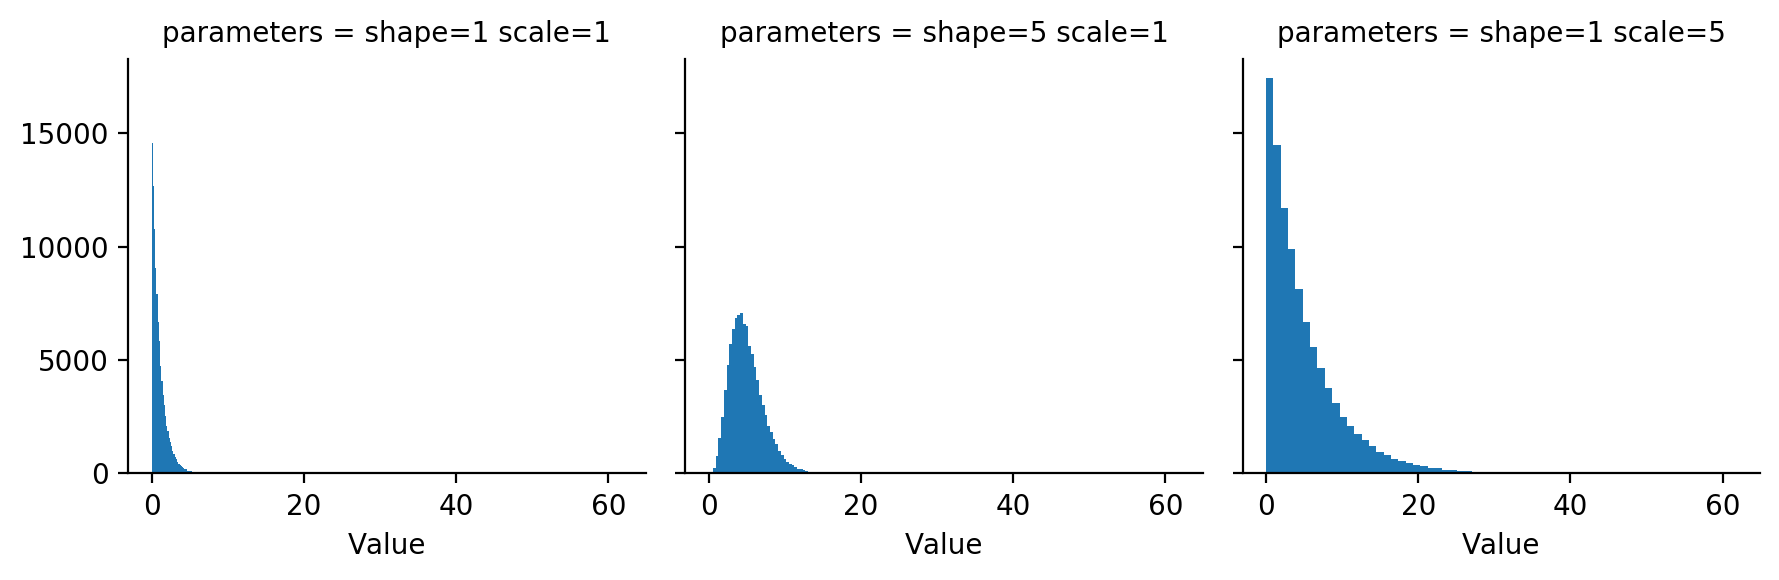

In [188]:
dfGamma = pd.DataFrame(data=gammaDistribution)

dfGammamelt = pd.melt(dfGamma,var_name='parameters',value_name='Value')


g = sns.FacetGrid(dfGammamelt,col="parameters",sharex=True)
g.map(plt.hist,'Value',cumulative=False,bins=64)

### Inverse-gamma distribution with different params

In [189]:
from scipy.stats import invgamma

invGammaDistribution={
    "shape=1 scale=1":invgamma.rvs(a=1,scale=1,size=100000),
    "shape=5 scale=1":invgamma.rvs(a=5,scale=1,size=100000),
    "shape=5 scale=5":invgamma.rvs(a=5,scale=5,size=100000),
}

### Due to plots, we can observe how value of shape and scale params affect on inverse-gamma distriibution

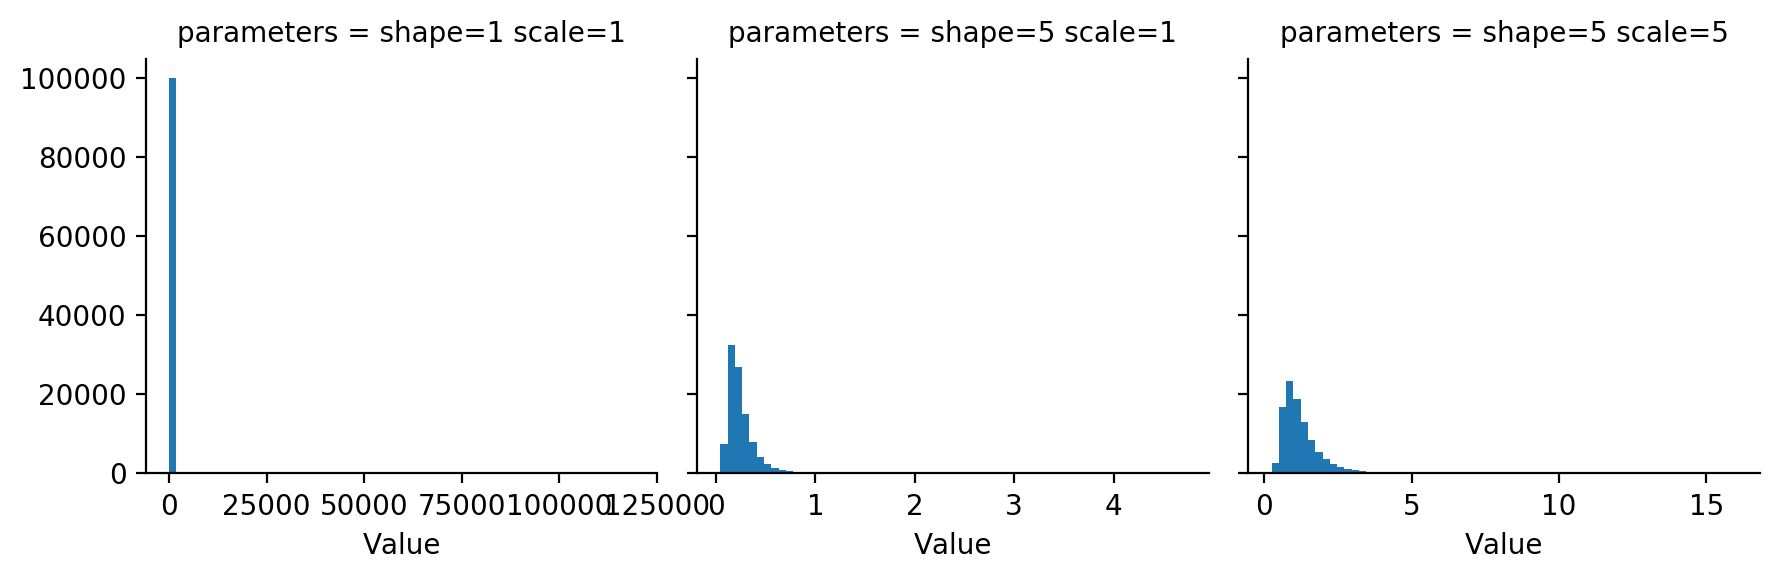

In [190]:
dfinvGamma = pd.DataFrame(data=invGammaDistribution)

dfinvGammamelt = pd.melt(dfinvGamma,var_name='parameters',value_name='Value')


g = sns.FacetGrid(dfinvGammamelt,col="parameters",sharex=False)
g.map(plt.hist,'Value',cumulative=False,bins=64)

### Impotring libs to use stan

In [191]:
import sys
import pystan
import stan_utility

import arviz as az
import scipy.stats as stats

### Some plot settings as in example 

In [192]:
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

### Finding parameters for Gamma distribution which 98% probability is for values between 5 and 10. In this case was used stan file with algebra_solver. It was created based on Airlines.ipynb

In [193]:
with open('prior_tune_gamma.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    //values between 5 and 10 with probabilty 98%, so 1% lesser than 5 and 1% greater than 10
    deltas[1] = gamma_cdf(theta[1], y[1], y[2]) -0.01; //only 1% will be lesser than 5
    deltas[2] = gamma_cdf(theta[2], y[1], y[2]) -0.99; //olny 1% will be greater than 10
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of gamma params
  vector<lower=0>[2] theta;     // Target quantile
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Due to RuntimeError, relative tolerance was decrease to 1e-2 and max num_stes was increase do 1e6
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i,1e-10,1e-2,1e6);

  print("alpha = ", y[1]);
  print("beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2];
}



In [194]:
tuning=stan_utility.compile_model('prior_tune_gamma.stan')

Using cached StanModel


### Compilation finished without error, so model was used to find params values. Starting from alpha=2 and betha=1, values of theta is our range. It allows to determine alpha and beta

In [195]:
data=dict(y_guess=np.array([2,1]),theta=np.array([5,10]))
tuned= tuning.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1, 
                            warmup=0,
                            chains=1)

alpha = np.round(tuned.extract()['alpha'][0])
beta = np.round(tuned.extract()['beta'][0])

print(alpha,beta)

46.0 6.0


### Before sampling, I checked if found values make sense. Seems, everything is okay, because most values are between 5 and 10.

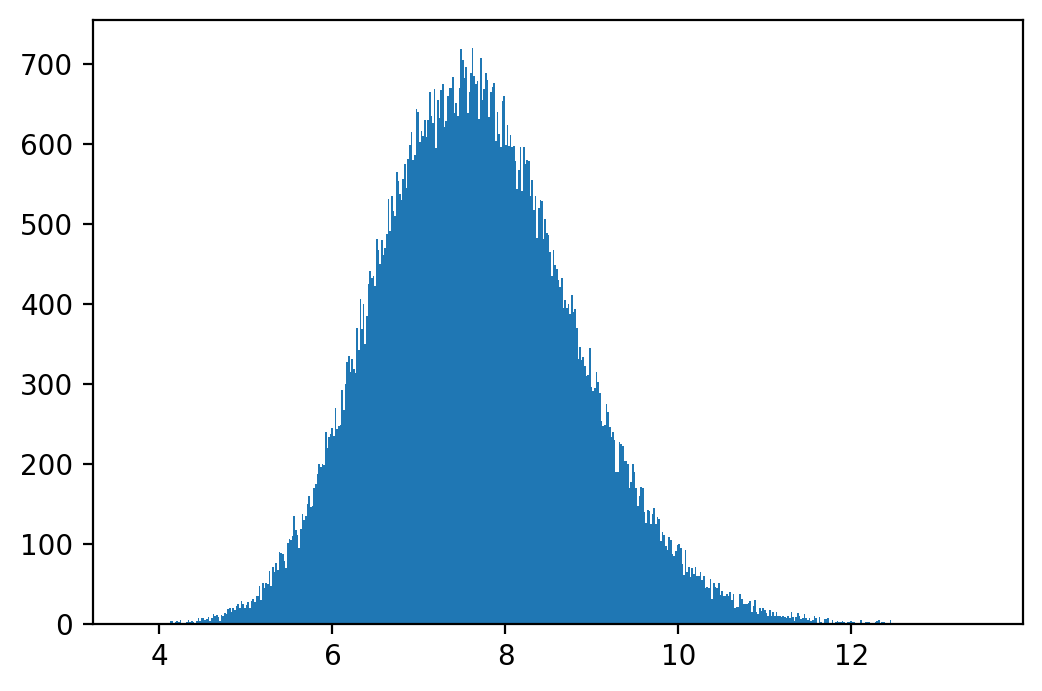

In [196]:
gamma = np.random.gamma(shape=alpha,scale=1/beta,size=100000)
gammaHist = plt.hist(gamma, bins=512)

### Model of gamma distribution in stan

In [197]:
with open('gamma.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}

parameters {
    real y;
}

model {
    y ~ gamma(alpha, beta);
}



In [198]:
gamma_model=stan_utility.compile_model('gamma.stan')

Using cached StanModel


### Using stan model to plot gamma distribution. We can observe that most of values are bettwen 5 and 10 and the meean is equal 7.683

Mean value : 7.683


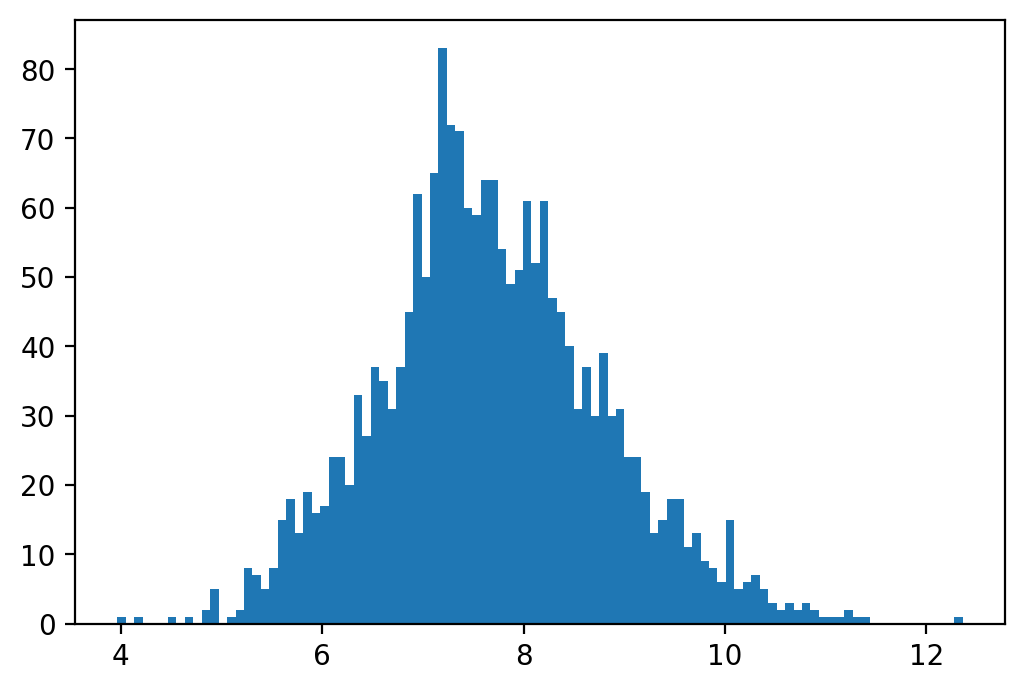

In [216]:
data=dict(alpha=alpha,
            beta = beta)
gamma_sampling=gamma_model.sampling(data=data,
                                      iter=1000,
                                      seed=10521020)

params=gamma_sampling.extract()
gammaSamplingHist=plt.hist(params['y'], bins=100)

mean_y = np.mean(params['y'])
print('Mean value : {:5.3f}'.format(mean_y))

### Finding parameters for inverse-gamma distribution which 98% probability is for values between 5 and 10. Everything was made similar as in case of gamma distribution.

In [200]:
with open('prior_tune_invgamma.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[2] deltas;
    //values between 5 and 10 with probabilty 98%, so 1% lesser than 5 and 1% greater than 10
    deltas[1] = inv_gamma_cdf(theta[1], y[1], y[2]) -0.01; //only 1% will be lesser than 5
    deltas[2] = inv_gamma_cdf(theta[2], y[1], y[2]) -0.99; //olny 1% will be greater than 10
    return deltas;
  }
}

data {
  vector<lower=0>[2] y_guess; // Initial guess of gamma params
  vector<lower=0>[2] theta;     // Target quantile
}

transformed data {

  vector[2] y;
  real x_r[0];
  int x_i[0];

  // Due to RuntimeError, relative tolerance was decrease to 1e-2 and max num_stes was increase do 1e6
  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i,1e-10,1.2e-2,1e6);

  print("alpha = ", y[1]);
  print("beta = ", y[2]);
}

generated quantities {
  real alpha = y[1];
  real beta = y[2];
}



In [203]:
tuning2=stan_utility.compile_model('prior_tune_invgamma.stan')

Using cached StanModel


In [208]:
data=dict(y_guess=np.array([0.5,0.4]),theta=np.array([5,10]))
tuned2= tuning2.sampling(data=data,
                            seed=1052020,
                            algorithm="Fixed_param",
                            iter=1, 
                            warmup=0,
                            chains=1)

alpha_inv = np.round(tuned2.extract()['alpha'][0])
beta_inv = np.round(tuned2.extract()['beta'][0])

print(alpha_inv,beta_inv)

62.0 399.0


In [209]:
with open('invgamma.stan', 'r') as file:
    print(file.read())

data {
    real<lower=0> alpha;
    real<lower=0> beta;
}

parameters {
    real y;
}

model {
    y ~ inv_gamma(alpha, beta);
}



In [210]:
invgamma_model=stan_utility.compile_model('invgamma.stan')

Using cached StanModel


Mean value : 6.566


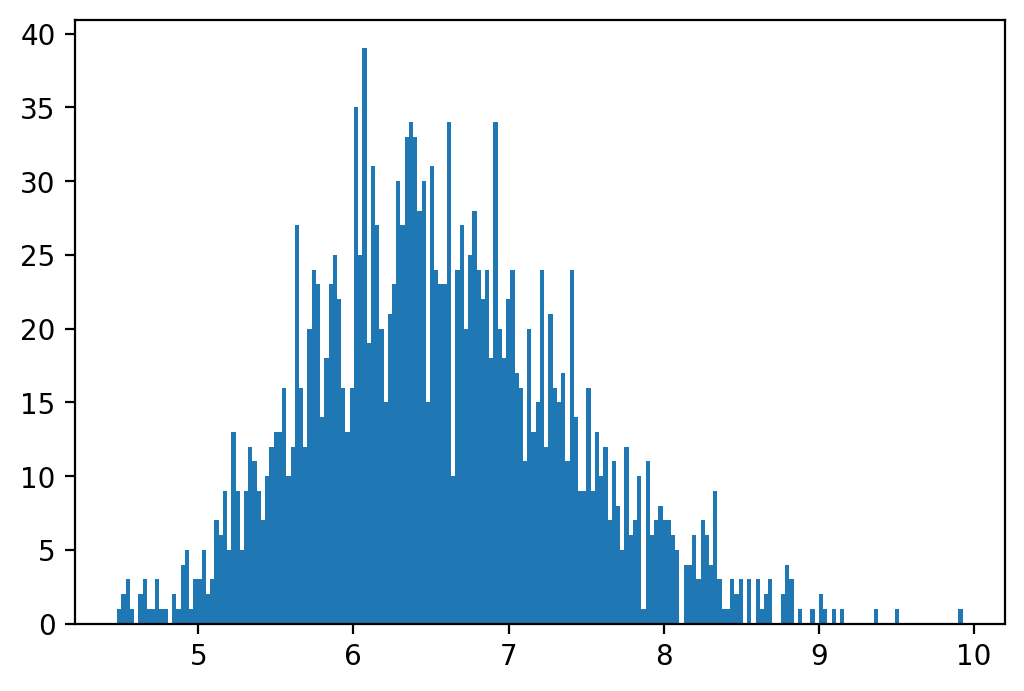

In [214]:
data=dict(alpha=alpha_inv,
            beta = beta_inv)
invgamma_sampling=invgamma_model.sampling(data=data,
                                      iter=1000,
                                      seed=10521020)

params_inv=invgamma_sampling.extract()
invgammaSamplingHist=plt.hist(params_inv['y'], bins=200)
mean_y = np.mean(params_inv['y'])
print('Mean value : {:5.3f}'.format(mean_y))

## In case inverse-gamma distribution, also most values are bettwen 5 and 10 (even 8), however more values are closer to 5, it's causing that mean is equal 6.566, where in case of gamma distribution it was 7.6.